In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import gc
from fastai.structured import *
from fastai.column_data import *
from sklearn.cluster import MiniBatchKMeans
# np.set_printoptions(threshold=50, edgeitems=20)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = 'data/NYC-taxi-fare-prediction'

In [4]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
        if i%10==0:
            print("finished k={} clustering".format(i))
    plt.figure(figsize=(12, 8))
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

def manhatt_dist(df, p_LAT='p_LAT', p_LONG='p_LONG', d_LAT='d_LAT', d_LONG='d_LONG'):
    LAT_dist = np.abs(df[p_LAT]-df[d_LAT])
    LONG_dist = np.abs(df[p_LONG]-df[d_LONG])
    return pd.DataFrame({'LAT_dist':LAT_dist, 'LONG_dist':LONG_dist})

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

def add_datetime(df, col):
    fld = pd.to_datetime(df[col], infer_datetime_format=True)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
           'Hour', 'Minute']
    res = pd.DataFrame()
    for n in attr:
        res[n] = getattr(fld.dt, n.lower())
    return res

def rmse(y_pred,targ): return np.sqrt(torch.mean((targ-y_pred)**2))

In [5]:
train_df = pd.read_csv(f'{PATH}/train.csv',index_col='key')
test_df = pd.read_csv(f'{PATH}/test.csv', index_col='key')

In [6]:
train_df.head()

fare_amount          pickup_datetime  \
key                                                                   
2009-06-15 17:26:21.0000001            4.5  2009-06-15 17:26:21 UTC   
2010-01-05 16:52:16.0000002           16.9  2010-01-05 16:52:16 UTC   
2011-08-18 00:35:00.00000049           5.7  2011-08-18 00:35:00 UTC   
2012-04-21 04:30:42.0000001            7.7  2012-04-21 04:30:42 UTC   
2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844311        40.721319   
2010-01-05 16:52:16.0000002          -74.016048        40.711303   
2011-08-18 00:35:00.00000049         -73.982738        40.761270   
2012-04-21 04:30:42.0000001          -73.987130        40.733143   
2010-03-09 07:51:00.000000135        -73.968095        40.768008   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841610         40.712278   
2010-01-05 16:52:16.0000002           -73.979268         40.782004   
2011-08-18 00:35:00.00000049          -73.991242         40.750562   
2012-04-21 04:30:42.0000001           -73.991567         40.758092   
2010-03-09 07:51:00.000000135         -73.956655         40.783762   

                               passenger_count  
key                                             
2009-06-15 17:26:21.0000001                  1  
2010-01-05 16:52:16.0000002                  1  
2011-08-18 00:35:00.00000049                 2  
2012-04-21 04:30:42.0000001                  1  
2010-03-09 07:51:00.000000135                1

## Exploring data

In [7]:
print(train_df.shape)
print(test_df.shape)

(55423856, 7)
(9914, 6)


In [8]:
# There are small amount of na in training set
train_df.isna().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [9]:
# no na in test set
test_df.isna().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

- Training set has abnormal data in each column.
- Test set, on the other hand, seems to have all the data within reasonable range

In [10]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.542386e+07      5.542386e+07     5.542386e+07       5.542348e+07   
mean   1.134505e+01     -7.250968e+01     3.991979e+01      -7.251121e+01   
std    2.071083e+01      1.284888e+01     9.642353e+00       1.278220e+01   
min   -3.000000e+02     -3.442060e+03    -3.492264e+03      -3.442025e+03   
25%    6.000000e+00     -7.399207e+01     4.073493e+01      -7.399140e+01   
50%    8.500000e+00     -7.398180e+01     4.075265e+01      -7.398015e+01   
75%    1.250000e+01     -7.396708e+01     4.076713e+01      -7.396367e+01   
max    9.396336e+04      3.457626e+03     3.408790e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      5.542348e+07     5.542386e+07  
mean       3.992068e+01     1.685380e+00  
std        9.633346e+00     1.327664e+00  
min       -3.547887e+03     0.000000e+00  
25%        4.073403e+01     1.000000e+00  
50%        4.075316e+01     1.000000e+00  
75%        4.076810e+01     2.000000e+00  
max        3.537133e+03     2.080000e+02

In [11]:
test_df.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count       9914.000000      9914.000000        9914.000000       9914.000000   
mean         -73.974722        40.751041         -73.973657         40.751743   
std            0.042774         0.033541           0.039072          0.035435   
min          -74.252193        40.573143         -74.263242         40.568973   
25%          -73.992501        40.736125         -73.991247         40.735254   
50%          -73.982326        40.753051         -73.980015         40.754065   
75%          -73.968013        40.767113         -73.964059         40.768757   
max          -72.986532        41.709555         -72.990963         41.696683   

       passenger_count  
count      9914.000000  
mean          1.671273  
std           1.278747  
min           1.000000  
25%           1.000000  
50%           1.000000  
75%           2.000000  
max           6.000000

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55423856 entries, 2009-06-15 17:26:21.0000001 to 2014-12-12 11:33:00.00000015
Data columns (total 7 columns):
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.3+ GB


change datatype to save memory

In [13]:
for col in train_df.columns:
    if train_df[col].dtype=='float64' or train_df[col].dtype=='int64':
        train_df[col] = train_df[col].astype('float32')

In [14]:
for col in test_df.columns:
    if test_df[col].dtype=='float64' or test_df[col].dtype=='int64':
        test_df[col] = test_df[col].astype('float32')

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55423856 entries, 2009-06-15 17:26:21.0000001 to 2014-12-12 11:33:00.00000015
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      float32
dtypes: float32(6), object(1)
memory usage: 2.1+ GB


In [19]:
BB_test = [max(test_df.pickup_latitude.max(), test_df.dropoff_latitude.max()),
           min(test_df.pickup_latitude.min(), test_df.dropoff_latitude.min()),
           max(test_df.pickup_longitude.max(), test_df.dropoff_longitude.max()),
           min(test_df.pickup_longitude.min(), test_df.dropoff_longitude.min())]
BB_train = [max(train_df.pickup_latitude.max(), train_df.dropoff_latitude.max()),
           min(train_df.pickup_latitude.min(), train_df.dropoff_latitude.min()),
           max(train_df.pickup_longitude.max(), train_df.dropoff_longitude.max()),
           min(train_df.pickup_longitude.min(), train_df.dropoff_longitude.min())]
print(BB_train,'\n',BB_test, sep='')

[3537.1326, -3547.8867, 3457.6257, -3442.0596]
[41.709557, 40.568974, -72.986534, -74.263245]


## Cleaning training set, remove na and abnormal data. (coord in water?)

In [24]:
BB = [-75.5, -71.8, 40, 41.8] # min long, max long, min lat, max lat, respectively
fare_range = [2.5, 1000] # min and max fare
psg_range = [1, 7] # min and max number of passenger

In [21]:
# only small amount of na, those cases are dropped
train_df.dropna(inplace=True)

In [22]:
# remove trips with abnormal fare
train_df.drop(train_df.loc[(train_df.fare_amount<fare_range[0]) | (train_df.fare_amount>fare_range[1])]
              .index, axis=0, inplace=True)

In [23]:
# remove trips with abnormal coordinates
train_df.drop(train_df.loc[(train_df.pickup_longitude<BB[0]) | (train_df.pickup_longitude>BB[1])]
              .index, axis=0, inplace=True)
train_df.drop(train_df.loc[(train_df.dropoff_longitude<BB[0]) | (train_df.dropoff_longitude>BB[1])]
              .index, axis=0, inplace=True)
train_df.drop(train_df.loc[(train_df.pickup_latitude<BB[2]) | (train_df.pickup_latitude>BB[3])].index, 
              axis=0, inplace=True)
train_df.drop(train_df.loc[(train_df.dropoff_latitude<BB[2]) | (train_df.dropoff_latitude>BB[3])].index, 
              axis=0, inplace=True)

In [25]:
# remove rows with abnormal passengers
train_df.drop(train_df.loc[(train_df.passenger_count<psg_range[0]) | 
                           (train_df.passenger_count>psg_range[1])]
              .index, axis=0, inplace=True)

In [26]:
train_df.shape

(54066507, 7)

In [27]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.406651e+07      5.406651e+07     5.406651e+07       5.406651e+07   
mean   1.133197e+01     -7.397074e+01     4.075013e+01      -7.397051e+01   
std    9.699717e+00      4.053497e-02     3.000706e-02       3.933000e-02   
min    2.500000e+00     -7.549814e+01     4.000000e+01      -7.549931e+01   
25%    6.000000e+00     -7.399229e+01     4.073656e+01      -7.399159e+01   
50%    8.500000e+00     -7.398209e+01     4.075337e+01      -7.398061e+01   
75%    1.250000e+01     -7.396830e+01     4.076756e+01      -7.396535e+01   
max    9.780000e+02     -7.186266e+01     4.179178e+01      -7.185725e+01   

       dropoff_latitude  passenger_count  
count      5.406651e+07     5.406651e+07  
mean       4.075022e+01     1.691119e+00  
std        3.321180e-02     1.306931e+00  
min        4.000000e+01     1.000000e+00  
25%        4.073558e+01     1.000000e+00  
50%        4.075386e+01     1.000000e+00  
75%        4.076840e+01     2.000000e+00  
max        4.179935e+01     7.000000e+00

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54066507 entries, 2009-06-15 17:26:21.0000001 to 2014-12-12 11:33:00.00000015
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      float32
dtypes: float32(6), object(1)
memory usage: 2.0+ GB


In [29]:
train_df.head()

fare_amount          pickup_datetime  \
key                                                                   
2009-06-15 17:26:21.0000001            4.5  2009-06-15 17:26:21 UTC   
2010-01-05 16:52:16.0000002           16.9  2010-01-05 16:52:16 UTC   
2011-08-18 00:35:00.00000049           5.7  2011-08-18 00:35:00 UTC   
2012-04-21 04:30:42.0000001            7.7  2012-04-21 04:30:42 UTC   
2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

                               pickup_longitude  pickup_latitude  \
key                                                                
2009-06-15 17:26:21.0000001          -73.844315        40.721317   
2010-01-05 16:52:16.0000002          -74.016045        40.711304   
2011-08-18 00:35:00.00000049         -73.982735        40.761269   
2012-04-21 04:30:42.0000001          -73.987129        40.733143   
2010-03-09 07:51:00.000000135        -73.968094        40.768009   

                               dropoff_longitude  dropoff_latitude  \
key                                                                  
2009-06-15 17:26:21.0000001           -73.841614         40.712276   
2010-01-05 16:52:16.0000002           -73.979271         40.782005   
2011-08-18 00:35:00.00000049          -73.991241         40.750561   
2012-04-21 04:30:42.0000001           -73.991570         40.758091   
2010-03-09 07:51:00.000000135         -73.956657         40.783764   

                               passenger_count  
key                                             
2009-06-15 17:26:21.0000001                1.0  
2010-01-05 16:52:16.0000002                1.0  
2011-08-18 00:35:00.00000049               2.0  
2012-04-21 04:30:42.0000001                1.0  
2010-03-09 07:51:00.000000135              1.0

In [30]:
train_df.to_pickle(f'{PATH}/train_cln')

In [24]:
test_df.to_pickle(f'{PATH}/test_cln')

In [41]:
gc.collect()

160

In [4]:
train_df = pd.read_pickle(f'{PATH}/train_cln')
test_df = pd.read_pickle(f'{PATH}/test_cln')

## Feature engineering

In [5]:
# change some column names
COLNAMES = {'pickup_datetime':'DT', 'pickup_longitude':'p_LONG',
           'pickup_latitude':'p_LAT', 'dropoff_longitude':'d_LONG',
           'dropoff_latitude':'d_LAT', 'passenger_count':'passenger'}
train_df.rename(columns=COLNAMES, inplace=True)
test_df.rename(columns=COLNAMES, inplace=True)

<b>cluster locations </b> : the idea is to use categorical label of location as input feature, and let embeding layers to learn the relationship between different labels.

In [46]:
mapper_p={'p_LONG':'LONG', 'p_LAT':'LAT'}
mapper_d={'d_LONG':'LONG', 'd_LAT':'LAT'}

In [52]:
loc_df = pd.concat((train_df.loc[:, ['p_LONG', 'p_LAT']].rename(columns=mapper_p), 
                    train_df.loc[:, ['d_LONG', 'd_LAT']].rename(columns=mapper_d),
                    test_df.loc[:, ['p_LONG', 'p_LAT']].rename(columns=mapper_p), 
                    test_df.loc[:, ['d_LONG', 'd_LAT']].rename(columns=mapper_d),), 
                   ignore_index=True, verify_integrity=True)
loc_df.describe()

LONG           LAT
count  1.081528e+08  1.081528e+08
mean  -7.398421e+01  4.075007e+01
std    3.993960e-02  3.165107e-02
min   -7.549931e+01  4.000000e+01
25%   -7.399194e+01  4.073611e+01
50%   -7.398145e+01  4.075362e+01
75%   -7.396700e+01  4.076803e+01
max   -7.185725e+01  4.179935e+01

In [60]:
loc_df.shape

(108152842, 2)

In [58]:
loc_df.to_pickle(f'{PATH}/all_coords')

In [6]:
loc_df = pd.read_pickle(f'{PATH}/all_coords')

In [9]:
def select_within_boundingbox(df, BB):
    return (df.LONG >= BB[0]) & (df.LONG <= BB[1]) & \
           (df.LAT >= BB[2]) & (df.LAT <= BB[3])

def plot_locs(df, frac=None, BB=None, map_img=None, figsize=(12, 12), ax=None, c='b'):
    if not frac:
        df_sample = df.sample(frac=frac)
    else:
        df_sample = df
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if BB:
        idx = select_within_boundingbox(df_sample, BB)
        ax.scatter(df_sample[idx].LONG, df_sample[idx].LAT, c=c, s=0.001, alpha=0.4)
    else:
        BB = (-75.5, -71.8, 40, 41.8)
        ax.imshow(map_img, zorder=0, extent=BB)
        ax.scatter(df_sample.LONG, df_sample.LAT, c=c, s=0.001, alpha=0.4)

In [11]:
BB=(-75.5, -71.8, 40, 41.8)
nyc_map = plt.imread(f'{PATH}/NYC_full.PNG')

# BB: [-74.1, -73.7, 40.6, 40.9]
# nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

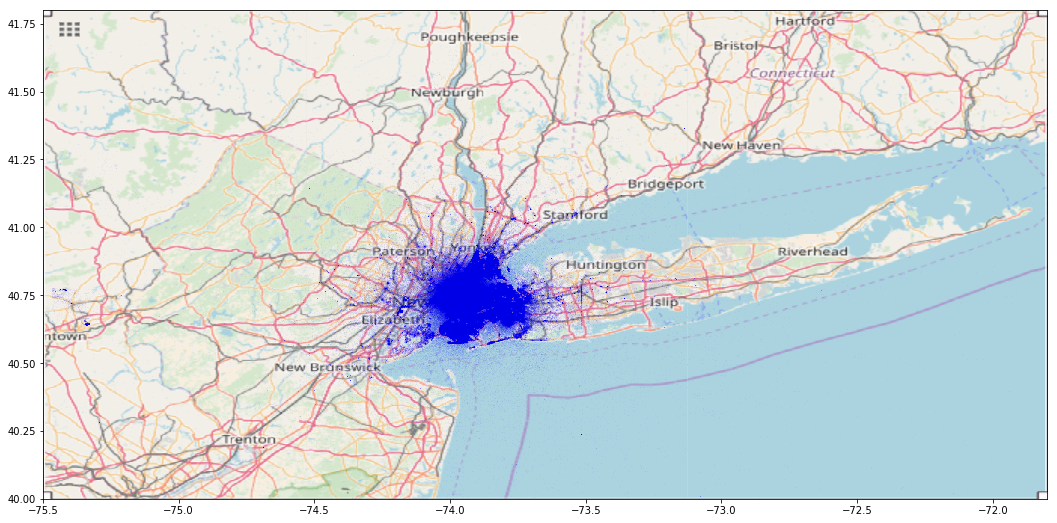

In [10]:
# plot the pickup and dropoff locations in train and test set (sample 20% points)
plot_locs(loc_df, frac=0.2, map_img=nyc_map, figsize=(18,9))

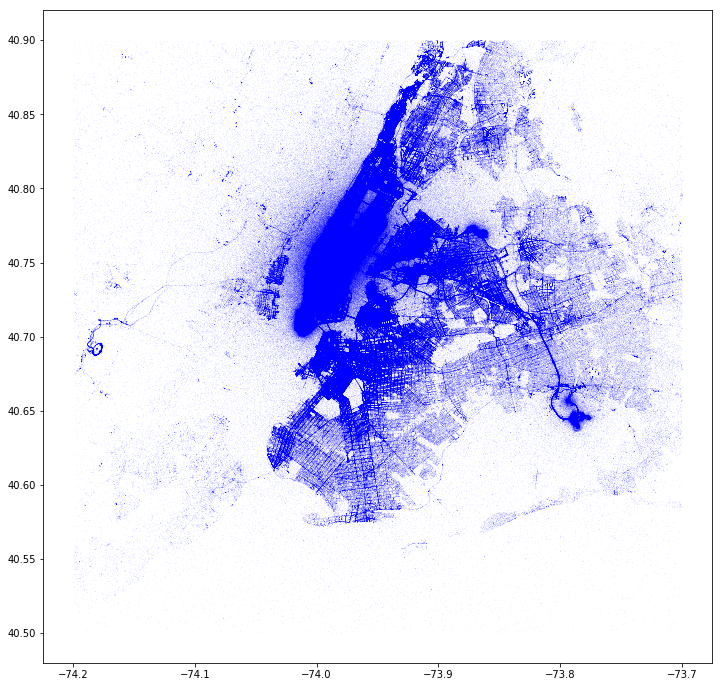

In [13]:
# zoom in to check nyc area
plot_locs(loc_df, frac=0.2, BB=(-74.2, -73.7, 40.5, 40.9))

finished k=10 clustering
finished k=20 clustering
finished k=30 clustering
finished k=40 clustering
finished k=50 clustering
finished k=60 clustering
finished k=70 clustering


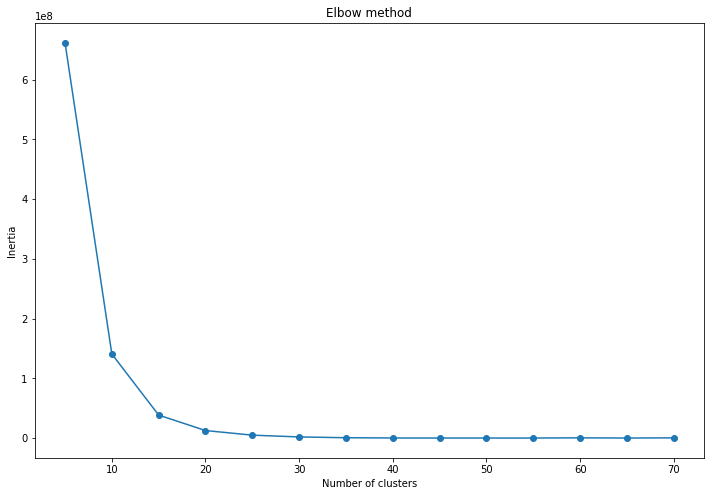

In [26]:
# using KMeans would be too slow
minibatchkmeans = MiniBatchKMeans(batch_size=100000, random_state=2)
plot_inertia(minibatchkmeans, loc_df, range(5, 75, 5))

In [7]:
loc_df = pd.read_pickle(f'{PATH}/all_coords')
MBKm = MiniBatchKMeans(n_clusters=50, random_state=2, batch_size=100000, n_init = 10).fit(loc_df)

In [8]:
loc_df['label'] = MBKm.labels_

In [9]:
loc_df.head()

LONG        LAT  label
0 -73.844315  40.721317      5
1 -74.016045  40.711304      4
2 -73.982735  40.761269     27
3 -73.987129  40.733143     25
4 -73.968094  40.768009     14

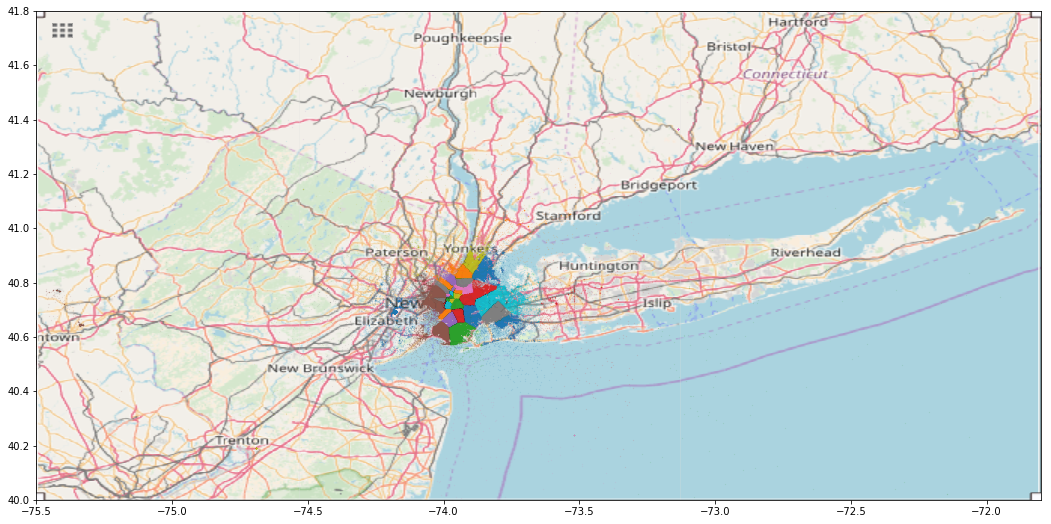

In [12]:
loc_df_s = loc_df.sample(frac=0.1)
plt.figure(figsize = (18,9))
plt.imshow(nyc_map, zorder=0, extent=BB)
for label in loc_df_s.label.unique():
    plt.plot(loc_df_s.LONG[loc_df_s.label == label],
             loc_df_s.LAT[loc_df_s.label == label],
             '.', alpha = 0.3, markersize = 0.3)

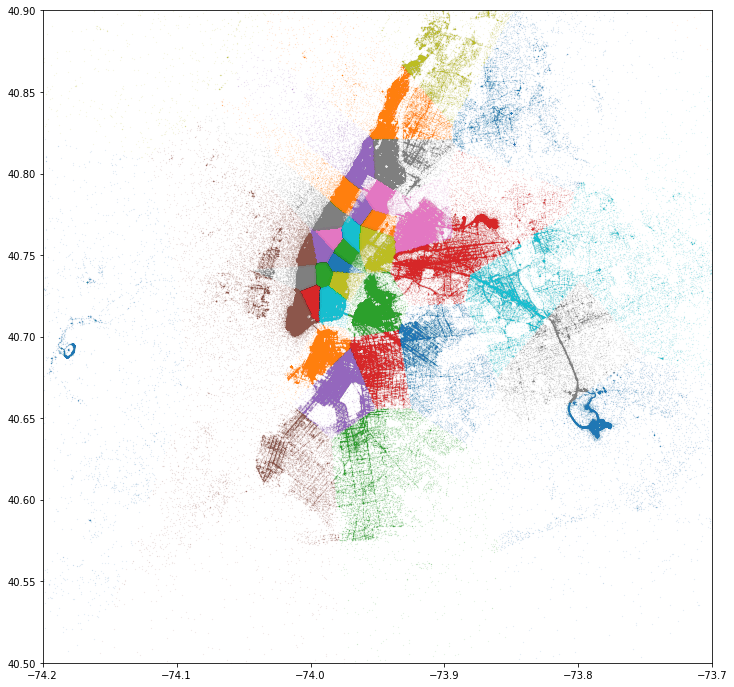

In [13]:
plt.figure(figsize = (12,12))
# plt.imshow(nyc_map, zorder=0, extent=BB)
for label in loc_df_s.label.unique():
    plt.plot(loc_df_s.LONG[loc_df_s.label == label],
             loc_df_s.LAT[loc_df_s.label == label],
             '.', alpha = 0.3, markersize = 0.3)
plt.xlim(-74.2, -73.7)
plt.ylim(40.5, 40.9)
plt.show()

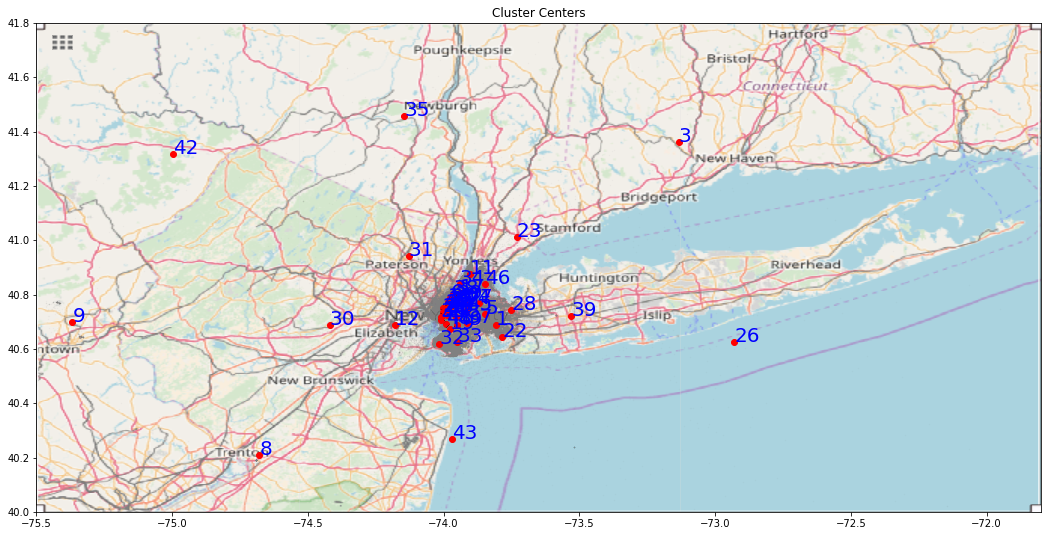

In [14]:
fig,ax = plt.subplots(figsize = (18,9))
ax.imshow(nyc_map, zorder=0, extent=BB)
for label in loc_df_s.label.unique():
    ax.plot(loc_df_s.LONG[loc_df_s.label == label],loc_df_s.LAT[loc_df_s.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(MBKm.cluster_centers_[label,0],MBKm.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (MBKm.cluster_centers_[label,0],MBKm.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

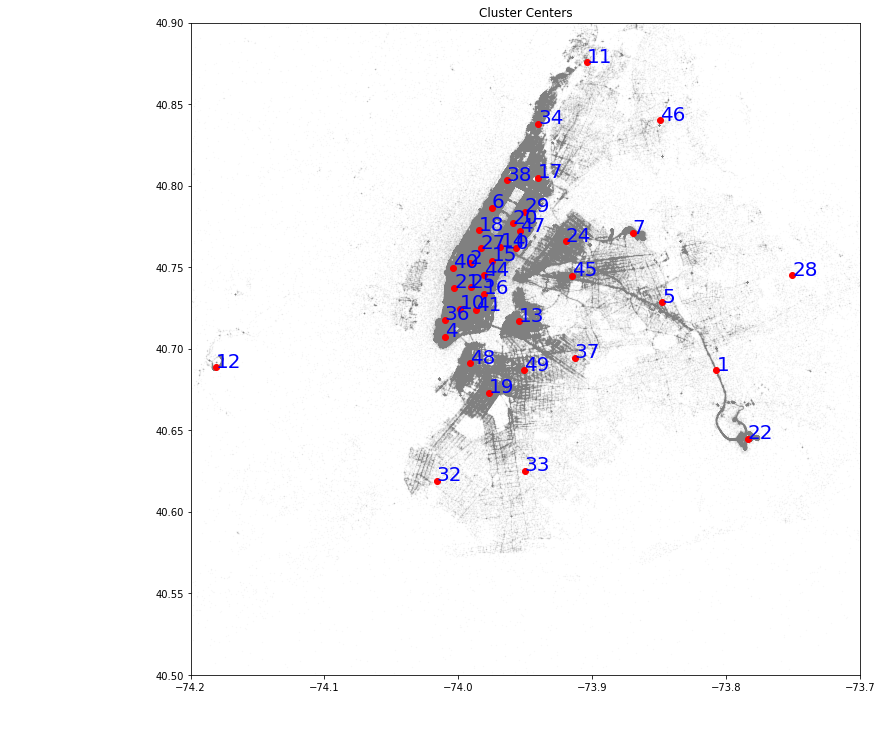

In [15]:
fig,ax = plt.subplots(figsize = (12,12))
# ax.imshow(nyc_map, zorder=0, extent=BB)
for label in loc_df_s.label.unique():
    ax.plot(loc_df_s.LONG[loc_df_s.label == label],loc_df_s.LAT[loc_df_s.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(MBKm.cluster_centers_[label,0],MBKm.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (MBKm.cluster_centers_[label,0],MBKm.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
ax.set_xlim(left=-74.2, right=-73.7)
ax.set_ylim(bottom=40.5, top=40.9)
plt.show()

In [16]:
l_trn = train_df.shape[0]
l_tst = test_df.shape[0]

train_label = pd.DataFrame(np.stack((loc_df.label[:l_trn],
                                     loc_df.label[l_trn:l_trn*2]), axis=1), 
                           columns=['p_label','d_label'], index=train_df.index)
test_label = pd.DataFrame(np.stack((loc_df.label[l_trn*2:l_trn*2+l_tst],
                                     loc_df.label[l_trn*2+l_tst:]), axis=1), 
                           columns=['p_label','d_label'], index=test_df.index)

In [19]:
train_label.head()

p_label  d_label
key                                            
2009-06-15 17:26:21.0000001          5        5
2010-01-05 16:52:16.0000002          4        6
2011-08-18 00:35:00.00000049        27        2
2012-04-21 04:30:42.0000001         25        2
2010-03-09 07:51:00.000000135       14       29

In [20]:
test_label.head()

p_label  d_label
key                                          
2015-01-27 13:08:24.0000002       14       44
2015-01-27 13:08:24.0000003       41       21
2011-10-08 11:53:44.0000002       44       44
2012-12-01 21:12:12.0000002       18        2
2012-12-01 21:12:12.0000003        6       25

In [18]:
train_label.to_pickle(f'{PATH}/train_cluster')
test_label.to_pickle(f'{PATH}/test_cluster')

## Simplest model with just LAT and LONG difference

In [7]:
train_simple = manhatt_dist(train_df)
train_simple['passenger'] = train_df['passenger']
train_simple['fare_amount'] = train_df['fare_amount']
train_simple.head()

LAT_dist  LONG_dist  passenger  fare_amount
key                                                                       
2009-06-15 17:26:21.0000001    0.009041   0.002701        1.0          4.5
2010-01-05 16:52:16.0000002    0.070702   0.036774        1.0         16.9
2011-08-18 00:35:00.00000049   0.010708   0.008507        2.0          5.7
2012-04-21 04:30:42.0000001    0.024948   0.004440        1.0          7.7
2010-03-09 07:51:00.000000135  0.015755   0.011436        1.0          5.3

In [8]:
test_simple = manhatt_dist(test_df)
test_simple['passenger'] = test_df['passenger']
test_simple.head()

LAT_dist  LONG_dist  passenger
key                                                        
2015-01-27 13:08:24.0000002  0.019970   0.008110        1.0
2015-01-27 13:08:24.0000003  0.019817   0.012024        1.0
2011-10-08 11:53:44.0000002  0.005119   0.002869        1.0
2012-12-01 21:12:12.0000002  0.016171   0.009285        1.0
2012-12-01 21:12:12.0000003  0.045349   0.022514        1.0

In [9]:
cat_vars = []
contin_vars = ['LAT_dist', 'LONG_dist', 'passenger']
dep = 'fare_amount'
n = train_df.shape[0]

In [10]:
train = train_simple[cat_vars+contin_vars+[dep]].copy()
test_simple[dep] = 0
test = test_simple[cat_vars+contin_vars+[dep]].copy()

In [11]:
for v in contin_vars: 
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')
train.head()

LAT_dist  LONG_dist  passenger  fare_amount
key                                                                       
2009-06-15 17:26:21.0000001    0.009041   0.002701        1.0          4.5
2010-01-05 16:52:16.0000002    0.070702   0.036774        1.0         16.9
2011-08-18 00:35:00.00000049   0.010708   0.008507        2.0          5.7
2012-04-21 04:30:42.0000001    0.024948   0.004440        1.0          7.7
2010-03-09 07:51:00.000000135  0.015755   0.011436        1.0          5.3

In [12]:
# use subset of training set to try
# idxs = get_cv_idxs(n, val_pct=10000000/n)
# train_samp = train.iloc[idxs]
train_samp = train.iloc[:10000000, :]   # used first 10000000 rows here, just to compare to linear regression result form kaggle kernal
samp_size = len(train_samp); samp_size

# to use full set:
# train_samp = train
# samp_size = n

10000000

In [13]:
df, y, nas, mapper = proc_df(train_samp, 'fare_amount', do_scale=True)
# yl = np.log(y)
df.head()

LAT_dist  LONG_dist  passenger
key                                                          
2009-06-15 17:26:21.0000001   -0.506730  -0.547834  -0.528686
2010-01-05 16:52:16.0000002    2.035684   0.377398  -0.528686
2011-08-18 00:35:00.00000049  -0.437995  -0.390176   0.236897
2012-04-21 04:30:42.0000001    0.149164  -0.500599  -0.528686
2010-03-09 07:51:00.000000135 -0.229902  -0.310622  -0.528686

In [14]:
df_test, _, nas, mapper = proc_df(test, 'fare_amount', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [15]:
val_idx = get_cv_idxs(samp_size, val_pct=0.25)
val_idx

array([ 919213, 9467153, 6585777, ..., 8817545, 4817836, 9060971])

In [16]:
def rmse(y_pred,targ): return np.sqrt(torch.mean((targ-y_pred)**2))

In [17]:
# def inv_y(a): return torch.exp(a)

# def rmse(y_pred,targ): return np.sqrt(torch.mean((targ-inv_y(y_pred))**2))

# # setting range of y?:
# # take log(y) as target?
# max_log_y = np.max(yl)
# y_range = (0, max_log_y*1.2)

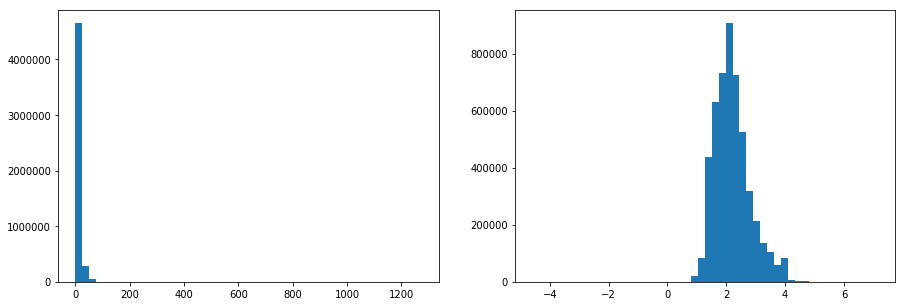

In [67]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(y,bins=50)
ax2.hist(yl,bins=50)
plt.show()

In [18]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=1024, test_df=df_test)

In [20]:
emb_sz = []

In [22]:
m = md.get_learner(emb_sz, len(df.columns)-len(cat_vars), emb_drop=0.0, out_sz=1, 
                   szs=[500], drops=[0.01]) #, y_range=y_range)
m

MixedInputModel(
  (embs): ModuleList(
  )
  (lins): ModuleList(
    (0): Linear(in_features=3, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.0)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True)
)

In [23]:
m.lr_find()

 80%|███████▉  | 5834/7325 [00:49<00:12, 118.29it/s, loss=0.328] 

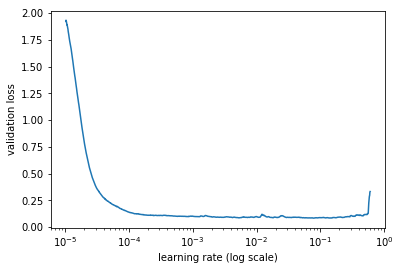

In [24]:
m.sched.plot()

In [27]:
lr = 1e-3
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                            
    0      0.078471   0.08008    12.70288  
    1      0.078844   0.080871   12.736128                       
    2      0.078759   0.079127   11.450711                       


[array([0.07913]), 11.450711490096904]

In [28]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse                            
    0      0.077734   0.078637   11.593587 
    1      0.076402   0.078626   11.570018                       
    2      0.077149   0.078621   11.59341                        


[array([0.07862]), 11.593409700165248]

In [29]:
m.fit(lr, 2, metrics=[rmse], cycle_len=3)

epoch      trn_loss   val_loss   rmse                            
    0      0.079045   0.078742   11.785828 
    1      0.076329   0.078809   11.747606                       
    2      0.077423   0.078594   11.587745                       
    3      0.080927   0.080058   11.633727                       
    4      0.078383   0.078709   11.491824                       
    5      0.078747   0.078582   11.598925                       


[array([0.07858]), 11.598924554771038]

| features | arch | parameters | rmse | note |
| --- | --- | --- | --- | --- |
| only LAT and LONG distance | No hidden layer | lr=1e-2 | ~5.74 | same as linear reg result from kaggle kernal | 
| only LAT and LONG distance | [100] | lr=1e-2 | ~4.57 | better than linear reg |
| only LAT and LONG distance | [500] | lr=2e-3 | ~4.56 | not much improve |
| LAT_dist, LONG_dist, passenger | [500] | lr=2e-3 | ~4.56 | passenger number doesn't seem to help |
|LAT_dist, LONG_dist, passenger | [500] | lr=1e-3 | ~11.59 | use log(y) as target, much worse |

-  No hidden layer, basically linear regression, lr=1e-2, rmse: ~5.74 (first 1/5 train), this is also the rmse got by linear regression on a kaggle kernal https://www.kaggle.com/dster/nyc-taxi-fare-starter-kernel-simple-linear-model
- with 1 hidden layer of size 100, lr=1e-2, rmse gets reduced to ~4.57, increasing size to 500 (lr=2e-3)only slightly further improve rmse to ~4.56
- using log(y) as target(so that the range of y can be set) dose not work as well as just using y
- Note: it's more complicate than simple linear relationship


##  How about just using the latitudes and longitudes, can neural network learn to calculate distance between two point?

In [62]:
train_coord = pd.DataFrame()
train_coord['fare_amount'] = train_df['fare_amount']
train_coord['p_LAT'] = train_df['p_LAT']
train_coord['p_LONG'] = train_df['p_LONG']
train_coord['d_LAT'] = train_df['d_LAT']
train_coord['d_LONG'] = train_df['d_LONG']
train_coord['passenger'] = train_df['passenger']
train_coord.head()

fare_amount      p_LAT     p_LONG      d_LAT  \
key                                                                           
2009-06-15 17:26:21.0000001            4.5  40.721317 -73.844315  40.712276   
2010-01-05 16:52:16.0000002           16.9  40.711304 -74.016045  40.782005   
2011-08-18 00:35:00.00000049           5.7  40.761269 -73.982735  40.750561   
2012-04-21 04:30:42.0000001            7.7  40.733143 -73.987129  40.758091   
2010-03-09 07:51:00.000000135          5.3  40.768009 -73.968094  40.783764   

                                  d_LONG  passenger  
key                                                  
2009-06-15 17:26:21.0000001   -73.841614        1.0  
2010-01-05 16:52:16.0000002   -73.979271        1.0  
2011-08-18 00:35:00.00000049  -73.991241        2.0  
2012-04-21 04:30:42.0000001   -73.991570        1.0  
2010-03-09 07:51:00.000000135 -73.956657        1.0

In [63]:
test_coord = pd.DataFrame()
test_coord['p_LAT'] = test_df['p_LAT']
test_coord['p_LONG'] = test_df['p_LONG']
test_coord['d_LAT'] = test_df['d_LAT']
test_coord['d_LONG'] = test_df['d_LONG']
test_coord['passenger'] = test_df['passenger']
test_coord.head()

p_LAT     p_LONG      d_LAT     d_LONG  \
key                                                                       
2015-01-27 13:08:24.0000002  40.763805 -73.973320  40.743835 -73.981430   
2015-01-27 13:08:24.0000003  40.719383 -73.986862  40.739201 -73.998886   
2011-10-08 11:53:44.0000002  40.751259 -73.982521  40.746140 -73.979652   
2012-12-01 21:12:12.0000002  40.767807 -73.981163  40.751637 -73.990448   
2012-12-01 21:12:12.0000003  40.789776 -73.966049  40.744427 -73.988564   

                             passenger  
key                                     
2015-01-27 13:08:24.0000002        1.0  
2015-01-27 13:08:24.0000003        1.0  
2011-10-08 11:53:44.0000002        1.0  
2012-12-01 21:12:12.0000002        1.0  
2012-12-01 21:12:12.0000003        1.0

In [64]:
cat_vars = []
contin_vars = ['p_LAT', 'p_LONG', 'd_LAT', 'd_LONG', 'passenger']
dep = 'fare_amount'
n = train_df.shape[0]

In [65]:
train = train_coord[cat_vars+contin_vars+[dep]].copy()
test_coord[dep] = 0
test = test_coord[cat_vars+contin_vars+[dep]].copy()

In [66]:
for v in contin_vars: 
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')

In [67]:
# use subset of training set to try
idxs = get_cv_idxs(n, val_pct=10000000/n)
train_samp = train.iloc[idxs]
samp_size = len(train_samp); samp_size

# to use full set:
# train_samp = train
# samp_size = n

10000000

In [68]:
df, y, nas, mapper = proc_df(train_samp, 'fare_amount', do_scale=True)
df.head()

p_LAT    p_LONG     d_LAT    d_LONG  \
key                                                                     
2011-04-07 11:51:27.0000003    0.637197  0.171790 -0.371588 -0.380570   
2010-05-18 09:03:00.00000046  -0.161215  0.063097 -0.156577  0.036865   
2015-05-21 09:44:30.0000006   -0.958231 -0.318648  0.476180  0.388859   
2010-04-17 18:18:00.000000121 -0.504971 -0.415306 -0.942847 -0.276018   
2013-04-09 22:08:00.00000088  -0.755865 -0.075309 -2.447579 -0.027802   

                               passenger  
key                                       
2011-04-07 11:51:27.0000003    -0.528772  
2010-05-18 09:03:00.00000046    2.530571  
2015-05-21 09:44:30.0000006    -0.528772  
2010-04-17 18:18:00.000000121  -0.528772  
2013-04-09 22:08:00.00000088   -0.528772

In [69]:
df_test, _, nas, mapper = proc_df(test, 'fare_amount', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [70]:
val_idx = get_cv_idxs(samp_size, val_pct=0.25)
val_idx

array([ 919213, 9467153, 6585777, ..., 8817545, 4817836, 9060971])

In [71]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=1024, test_df=df_test)

In [83]:
emb_sz = []
m = md.get_learner(emb_sz, len(df.columns)-len(cat_vars), emb_drop=0.0, out_sz=1, 
                   szs=[500, 100], drops=[0.001, 0.01]) #, y_range=yl_range)
m

MixedInputModel(
  (embs): ModuleList(
  )
  (lins): ModuleList(
    (0): Linear(in_features=5, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=100, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.0)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
)

In [84]:
m.lr_find(start_lr=1e-4,end_lr=10)

 70%|███████   | 5134/7325 [00:44<00:19, 114.77it/s, loss=48.8]

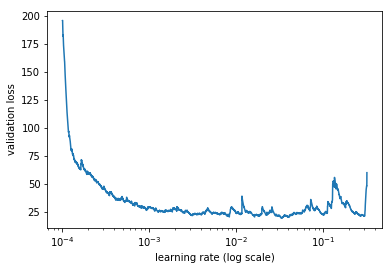

In [85]:
m.sched.plot()

In [86]:
lr = 1e-3
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                          
    0      20.892054  19.842832  4.361069  
    1      19.499966  19.216588  4.289158                      
    2      19.545751  18.973972  4.261503                      


[array([18.97397]), 4.2615030847205535]

In [87]:
m.fit(lr, 5, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse                          
    0      19.705575  18.456581  4.201533  
    1      18.63943   18.338933  4.187421                      
    2      18.492599  18.245462  4.176927                      
    3      20.288969  18.193874  4.17025                       
    4      17.34743   18.123629  4.162242                      


[array([18.12363]), 4.1622420622896295]

In [88]:
m.fit(lr, 2, metrics=[rmse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   rmse                          
    0      16.95851   18.21056   4.172325  
    1      17.885754  18.026249  4.150247                      
    2      16.522767  18.239891  4.174055                      
    3      19.311474  18.083762  4.155514                      
    4      20.576224  17.936505  4.140433                      
    5      16.969363  17.877885  4.132672                      


[array([17.87788]), 4.132671645598018]

| features | arch | parameters | rmse | note |
| --- | --- | --- | --- | --- |
| LAT, LONG and passenger | [100] | lr=1e-2 | ~4.31 | turns out to be better than using distance | 
| LAT, LONG and passenger | [500] | lr=2e-3 | ~4.26 | small improve | 
| LAT, LONG and passenger | [500, 100] drops=[0.001, 0.01] | lr=1e-3 | ~4.13 | some improve | 
| LAT, LONG and passenger | [1000,500,100] drops=[0.001, 0.03, 0.01] | lr=1e-3 | ~4.02 | very close to model using additional distance features | 
| LAT, LONG and passenger | [100, 1000,500,100] drops=[0.001, 0.001, 0.03, 0.01] | lr=1e-3 | ~4.00 | little improve | 

apparently, the network can figure out how to use LAT and LONG to calculate distance, it gives better result using just coordinates than calculated distances.

## using longitudes, latitudes and distances

In [44]:
# train_dist_coord = manhatt_dist(train_df)
train_dist_coord = pd.DataFrame()
train_dist_coord['dist'] = distance(train_df.p_LAT, train_df.p_LONG, 
                                    train_df.d_LAT, train_df.d_LONG)
train_dist_coord['fare_amount'] = train_df['fare_amount']
train_dist_coord['p_LAT'] = train_df['p_LAT']
train_dist_coord['p_LONG'] = train_df['p_LONG']
train_dist_coord['d_LAT'] = train_df['d_LAT']
train_dist_coord['d_LONG'] = train_df['d_LONG']
train_dist_coord['passenger'] = train_df['passenger']
train_dist_coord.head()

dist  fare_amount      p_LAT     p_LONG  \
key                                                                          
2009-06-15 17:26:21.0000001    0.640473          4.5  40.721317 -73.844315   
2010-01-05 16:52:16.0000002    5.250587         16.9  40.711304 -74.016045   
2011-08-18 00:35:00.00000049   0.863477          5.7  40.761269 -73.982735   
2012-04-21 04:30:42.0000001    1.739349          7.7  40.733143 -73.987129   
2010-03-09 07:51:00.000000135  1.242172          5.3  40.768009 -73.968094   

                                   d_LAT     d_LONG  passenger  
key                                                             
2009-06-15 17:26:21.0000001    40.712276 -73.841614        1.0  
2010-01-05 16:52:16.0000002    40.782005 -73.979271        1.0  
2011-08-18 00:35:00.00000049   40.750561 -73.991241        2.0  
2012-04-21 04:30:42.0000001    40.758091 -73.991570        1.0  
2010-03-09 07:51:00.000000135  40.783764 -73.956657        1.0

In [45]:
# test_dist_coord = manhatt_dist(test_df)
test_dist_coord = pd.DataFrame()
test_dist_coord['dist'] = distance(test_df.p_LAT, test_df.p_LONG, 
                                    test_df.d_LAT, test_df.d_LONG)
test_dist_coord['p_LAT'] = test_df['p_LAT']
test_dist_coord['p_LONG'] = test_df['p_LONG']
test_dist_coord['d_LAT'] = test_df['d_LAT']
test_dist_coord['d_LONG'] = test_df['d_LONG']
test_dist_coord['passenger'] = test_df['passenger']
test_dist_coord.head()

dist      p_LAT     p_LONG      d_LAT  \
key                                                                      
2015-01-27 13:08:24.0000002  1.366828  40.763805 -73.973320  40.743835   
2015-01-27 13:08:24.0000003  1.366828  40.719383 -73.986862  40.739201   
2011-10-08 11:53:44.0000002  0.000000  40.751259 -73.982521  40.746140   
2012-12-01 21:12:12.0000002  1.366828  40.767807 -73.981163  40.751637   
2012-12-01 21:12:12.0000003  3.226874  40.789776 -73.966049  40.744427   

                                d_LONG  passenger  
key                                                
2015-01-27 13:08:24.0000002 -73.981430        1.0  
2015-01-27 13:08:24.0000003 -73.998886        1.0  
2011-10-08 11:53:44.0000002 -73.979652        1.0  
2012-12-01 21:12:12.0000002 -73.990448        1.0  
2012-12-01 21:12:12.0000003 -73.988564        1.0

In [47]:
cat_vars = []
contin_vars = ['dist', 'p_LAT', 'p_LONG', 'd_LAT',
               'd_LONG', 'passenger']
dep = 'fare_amount'
n = train_df.shape[0]

In [48]:
train = train_dist_coord[cat_vars+contin_vars+[dep]].copy()
test_dist_coord[dep] = 0
test = test_dist_coord[cat_vars+contin_vars+[dep]].copy()

In [49]:
for v in contin_vars: 
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')
train.head()

dist      p_LAT     p_LONG      d_LAT  \
key                                                                        
2009-06-15 17:26:21.0000001    0.640473  40.721317 -73.844315  40.712276   
2010-01-05 16:52:16.0000002    5.250587  40.711304 -74.016045  40.782005   
2011-08-18 00:35:00.00000049   0.863477  40.761269 -73.982735  40.750561   
2012-04-21 04:30:42.0000001    1.739349  40.733143 -73.987129  40.758091   
2010-03-09 07:51:00.000000135  1.242172  40.768009 -73.968094  40.783764   

                                  d_LONG  passenger  fare_amount  
key                                                               
2009-06-15 17:26:21.0000001   -73.841614        1.0          4.5  
2010-01-05 16:52:16.0000002   -73.979271        1.0         16.9  
2011-08-18 00:35:00.00000049  -73.991241        2.0          5.7  
2012-04-21 04:30:42.0000001   -73.991570        1.0          7.7  
2010-03-09 07:51:00.000000135 -73.956657        1.0          5.3

In [50]:
# use subset of training set to try
idxs = get_cv_idxs(n, val_pct=10000000/n)
train_samp = train.iloc[idxs]
samp_size = len(train_samp); samp_size

# to use full set:
# train_samp = train
# samp_size = n

10000000

In [51]:
df, y, nas, mapper = proc_df(train_samp, 'fare_amount', do_scale=True)
df.head()

dist     p_LAT    p_LONG     d_LAT  \
key                                                                     
2011-04-07 11:51:27.0000003    0.139750  0.637197  0.171790 -0.371588   
2010-05-18 09:03:00.00000046  -0.858988 -0.161215  0.063097 -0.156577   
2015-05-21 09:44:30.0000006    0.576553 -0.958231 -0.318648  0.476180   
2010-04-17 18:18:00.000000121 -0.381020 -0.504971 -0.415306 -0.942847   
2013-04-09 22:08:00.00000088   0.810902 -0.755865 -0.075309 -2.447579   

                                 d_LONG  passenger  
key                                                 
2011-04-07 11:51:27.0000003   -0.380570  -0.528772  
2010-05-18 09:03:00.00000046   0.036865   2.530571  
2015-05-21 09:44:30.0000006    0.388859  -0.528772  
2010-04-17 18:18:00.000000121 -0.276018  -0.528772  
2013-04-09 22:08:00.00000088  -0.027802  -0.528772

In [52]:
df_test, _, nas, mapper = proc_df(test, 'fare_amount', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [53]:
val_idx = get_cv_idxs(samp_size, val_pct=0.25)
val_idx

array([ 919213, 9467153, 6585777, ..., 8817545, 4817836, 9060971])

In [54]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=1024, test_df=df_test)

In [55]:
emb_sz = []

In [56]:
m = md.get_learner(emb_sz, len(df.columns)-len(cat_vars), emb_drop=0.0, out_sz=1, 
                   szs=[1000, 500, 100], drops=[0.001, 0.03, 0.01]) #, y_range=yl_range)
m

MixedInputModel(
  (embs): ModuleList(
  )
  (lins): ModuleList(
    (0): Linear(in_features=6, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=100, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.0)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.03)
    (2): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True)
)

In [57]:
m.lr_find(start_lr=1e-4)

 54%|█████▎    | 3926/7325 [00:40<00:35, 95.76it/s, loss=73.2]

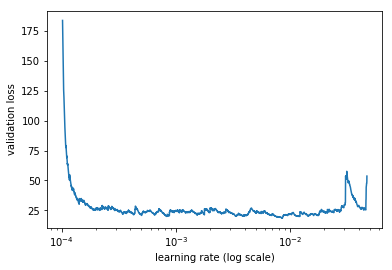

In [58]:
m.sched.plot()

In [59]:
lr = 1e-3
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                         
    0      19.819944  19.174805  4.286616  
    1      17.804734  18.143747  4.162553                     
    2      16.342603  17.820526  4.123901                     


[array([17.82053]), 4.123901099286361]

In [60]:
m.fit(lr, 5, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse                         
    0      15.970462  17.167942  4.049201  
    1      21.680721  17.083122  4.038224                     
    2      17.808717  17.061327  4.036314                     
    3      17.218027  17.039227  4.033476                     
    4      15.080654  16.999255  4.027949                     


[array([16.99925]), 4.027949156678101]

In [61]:
m.fit(lr, 2, metrics=[rmse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   rmse                         
    0      15.551636  17.131167  4.042615  
    1      16.072775  16.924471  4.018558                      
    2      17.46028   17.356763  4.070731                      
    3      21.879922  16.986999  4.027616                     
    4      15.337159  16.902542  4.014856                     
    5      16.616288  16.794     4.003213                     


[array([16.794]), 4.003213108299772]

| features | arch | parameters | rmse | note |
| --- | --- | --- | --- | --- |
| LAT, LONG, passenger, dist | [100] | lr=1e-2 | ~4.23 | some improve compared to without dist (4.31) | 
| LAT, LONG, passenger, dist | [500] | lr=1e-2 | ~4.20 | little improve | 
| LAT, LONG, passenger, dist | [500, 100], drops:[0.001, 0.01] | lr=1e-3 | ~4.05 | one more hidden layer improve result |
| LAT, LONG, passenger, dist | [1000, 500, 100], drops:[0.001, 0.03 0.01] | lr=1e-3 | ~3.99 | one more hidden layer slightly improve result |
| LAT, LONG, passenger, dist | [1000, 500, 100], drops:[0.001, 0.03 0.01] | lr=1e-3 | ~4.00 | using distance calculated with haversine formula instead, not improving |

## adding in datetime embedings

In [11]:
train_DT = add_datetime(train_df, 'DT')
train_DT['fare_amount'] = train_df['fare_amount']
train_DT['p_LAT'] = train_df['p_LAT']
train_DT['p_LONG'] = train_df['p_LONG']
train_DT['d_LAT'] = train_df['d_LAT']
train_DT['d_LONG'] = train_df['d_LONG']
train_DT['passenger'] = train_df['passenger']
train_DT.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                           
2009-06-15 17:26:21.0000001    2009      6    25   15          0        166   
2010-01-05 16:52:16.0000002    2010      1     1    5          1          5   
2011-08-18 00:35:00.00000049   2011      8    33   18          3        230   
2012-04-21 04:30:42.0000001    2012      4    16   21          5        112   
2010-03-09 07:51:00.000000135  2010      3    10    9          1         68   

                               Hour  Minute  fare_amount      p_LAT  \
key                                                                   
2009-06-15 17:26:21.0000001      17      26          4.5  40.721317   
2010-01-05 16:52:16.0000002      16      52         16.9  40.711304   
2011-08-18 00:35:00.00000049      0      35          5.7  40.761269   
2012-04-21 04:30:42.0000001       4      30          7.7  40.733143   
2010-03-09 07:51:00.000000135     7      51          5.3  40.768009   

                                  p_LONG      d_LAT     d_LONG  passenger  
key                                                                        
2009-06-15 17:26:21.0000001   -73.844315  40.712276 -73.841614        1.0  
2010-01-05 16:52:16.0000002   -74.016045  40.782005 -73.979271        1.0  
2011-08-18 00:35:00.00000049  -73.982735  40.750561 -73.991241        2.0  
2012-04-21 04:30:42.0000001   -73.987129  40.758091 -73.991570        1.0  
2010-03-09 07:51:00.000000135 -73.968094  40.783764 -73.956657        1.0

In [12]:
test_DT = add_datetime(test_df, 'DT')
test_DT['p_LAT'] = test_df['p_LAT']
test_DT['p_LONG'] = test_df['p_LONG']
test_DT['d_LAT'] = test_df['d_LAT']
test_DT['d_LONG'] = test_df['d_LONG']
test_DT['passenger'] = test_df['passenger']
test_DT.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                         
2015-01-27 13:08:24.0000002  2015      1     5   27          1         27   
2015-01-27 13:08:24.0000003  2015      1     5   27          1         27   
2011-10-08 11:53:44.0000002  2011     10    40    8          5        281   
2012-12-01 21:12:12.0000002  2012     12    48    1          5        336   
2012-12-01 21:12:12.0000003  2012     12    48    1          5        336   

                             Hour  Minute      p_LAT     p_LONG      d_LAT  \
key                                                                          
2015-01-27 13:08:24.0000002    13       8  40.763805 -73.973320  40.743835   
2015-01-27 13:08:24.0000003    13       8  40.719383 -73.986862  40.739201   
2011-10-08 11:53:44.0000002    11      53  40.751259 -73.982521  40.746140   
2012-12-01 21:12:12.0000002    21      12  40.767807 -73.981163  40.751637   
2012-12-01 21:12:12.0000003    21      12  40.789776 -73.966049  40.744427   

                                d_LONG  passenger  
key                                                
2015-01-27 13:08:24.0000002 -73.981430        1.0  
2015-01-27 13:08:24.0000003 -73.998886        1.0  
2011-10-08 11:53:44.0000002 -73.979652        1.0  
2012-12-01 21:12:12.0000002 -73.990448        1.0  
2012-12-01 21:12:12.0000003 -73.988564        1.0

In [13]:
cat_vars = ['Year','Month','Week','Day','Dayofweek','Dayofyear','Hour','Minute']
contin_vars = ['p_LAT', 'p_LONG', 'd_LAT', 'd_LONG', 'passenger']
dep = 'fare_amount'
n = train_df.shape[0]

In [16]:
train = train_DT[cat_vars+contin_vars+[dep]].copy()
test_DT[dep] = 0
test = test_DT[cat_vars+contin_vars+[dep]].copy()

In [17]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)
for v in contin_vars: 
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')
train.head()

Year Month Week Day Dayofweek Dayofyear Hour  \
key                                                                           
2009-06-15 17:26:21.0000001    2009     6   25  15         0       166   17   
2010-01-05 16:52:16.0000002    2010     1    1   5         1         5   16   
2011-08-18 00:35:00.00000049   2011     8   33  18         3       230    0   
2012-04-21 04:30:42.0000001    2012     4   16  21         5       112    4   
2010-03-09 07:51:00.000000135  2010     3   10   9         1        68    7   

                              Minute      p_LAT     p_LONG      d_LAT  \
key                                                                     
2009-06-15 17:26:21.0000001       26  40.721317 -73.844315  40.712276   
2010-01-05 16:52:16.0000002       52  40.711304 -74.016045  40.782005   
2011-08-18 00:35:00.00000049      35  40.761269 -73.982735  40.750561   
2012-04-21 04:30:42.0000001       30  40.733143 -73.987129  40.758091   
2010-03-09 07:51:00.000000135     51  40.768009 -73.968094  40.783764   

                                  d_LONG  passenger  fare_amount  
key                                                               
2009-06-15 17:26:21.0000001   -73.841614        1.0          4.5  
2010-01-05 16:52:16.0000002   -73.979271        1.0         16.9  
2011-08-18 00:35:00.00000049  -73.991241        2.0          5.7  
2012-04-21 04:30:42.0000001   -73.991570        1.0          7.7  
2010-03-09 07:51:00.000000135 -73.956657        1.0          5.3

In [18]:
# use subset of training set to try
idxs = get_cv_idxs(n, val_pct=10000000/n)
train_samp = train.iloc[idxs]
samp_size = len(train_samp); samp_size

# to use full set:
# train_samp = train
# samp_size = n

10000000

In [19]:
df, y, nas, mapper = proc_df(train_samp, 'fare_amount', do_scale=True)
df.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                           
2011-04-07 11:51:27.0000003       3      4    14    7          4         97   
2010-05-18 09:03:00.00000046      2      5    20   18          2        138   
2015-05-21 09:44:30.0000006       7      5    21   21          4        141   
2010-04-17 18:18:00.000000121     2      4    15   17          6        107   
2013-04-09 22:08:00.00000088      5      4    15    9          2         99   

                               Hour  Minute     p_LAT    p_LONG     d_LAT  \
key                                                                         
2011-04-07 11:51:27.0000003      12      52  0.637197  0.171790 -0.371588   
2010-05-18 09:03:00.00000046     10       4 -0.161215  0.063097 -0.156577   
2015-05-21 09:44:30.0000006      10      45 -0.958231 -0.318648  0.476180   
2010-04-17 18:18:00.000000121    19      19 -0.504971 -0.415306 -0.942847   
2013-04-09 22:08:00.00000088     23       9 -0.755865 -0.075309 -2.447579   

                                 d_LONG  passenger  
key                                                 
2011-04-07 11:51:27.0000003   -0.380570  -0.528772  
2010-05-18 09:03:00.00000046   0.036865   2.530571  
2015-05-21 09:44:30.0000006    0.388859  -0.528772  
2010-04-17 18:18:00.000000121 -0.276018  -0.528772  
2013-04-09 22:08:00.00000088  -0.027802  -0.528772

In [20]:
df_test, _, nas, mapper = proc_df(test, 'fare_amount', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [21]:
val_idx = get_cv_idxs(samp_size, val_pct=0.25)
val_idx

array([ 919213, 9467153, 6585777, ..., 8817545, 4817836, 9060971])

In [22]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=512, test_df=df_test)

In [23]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Year', 8),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 367),
 ('Hour', 25),
 ('Minute', 61)]

In [24]:
emb_sz = [(c,min(50, (c+1)//2)) for _,c in cat_sz]
emb_sz

[(8, 4), (13, 7), (54, 27), (32, 16), (8, 4), (367, 50), (25, 13), (61, 31)]

In [29]:
m = md.get_learner(emb_sz, len(df.columns)-len(cat_vars), emb_drop=0.04, out_sz=1, 
                   szs=[1000, 500, 100], drops=[0.001, 0.03, 0.01]) 
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(13, 7)
    (2): Embedding(54, 27)
    (3): Embedding(32, 16)
    (4): Embedding(8, 4)
    (5): Embedding(367, 50)
    (6): Embedding(25, 13)
    (7): Embedding(61, 31)
  )
  (lins): ModuleList(
    (0): Linear(in_features=157, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=100, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.03)
    (2): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
)

In [30]:
m.lr_find()

 58%|█████▊    | 8516/14649 [01:27<01:03, 97.31it/s, loss=59.5]

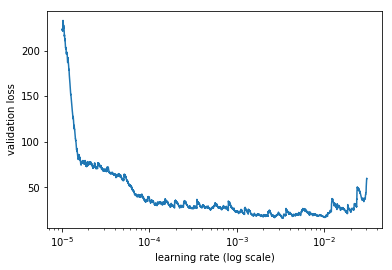

In [31]:
m.sched.plot()

In [32]:
lr = 1e-3
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                            
    0      19.996161  16.399444  3.896341  
    1      14.68763   15.243431  3.744376                       
    2      13.048266  15.205542  3.735439                        


[array([15.20554]), 3.7354394118386915]

In [33]:
m.fit(lr, 5, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse                           
    0      12.886647  14.611212  3.657119  
    1      14.438774  14.544875  3.64882                        
    2      12.22753   14.530059  3.646493                       
    3      12.835568  14.520431  3.643717                       
    4      13.180242  14.511288  3.641544                        


[array([14.51129]), 3.6415441880620105]

In [34]:
m.fit(lr, 2, metrics=[rmse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   rmse                            
    0      12.998264  14.659403  3.663571  
    1      12.829911  14.495532  3.639367                        
    2      12.090819  14.809875  3.678945                       
    3      14.314128  14.786532  3.681789                       
    4      11.98233   14.405189  3.626953                        
    5      14.732159  14.390248  3.623817                       


[array([14.39025]), 3.623816730383347]

| features | arch | parameters | rmse | note |
| --- | --- | --- | --- | --- |
| LAT, LONG, passenger, DT embeding | [1000, 500, 100], drops:[0.001, 0.03 0.01] | lr=1e-3 | ~3.63 | much better than with out date time features | 

- Using DT features significantly increased result

In [41]:
y_test=m.predict(True)

In [42]:
y_test = y_test.reshape(-1)

In [44]:
submission = pd.DataFrame(
    {'key': test_df.index, 'fare_amount': y_test},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission1.csv', index = False)

In [46]:
m.save('CoordWithDTEmbed')

## adding location clustering feature

In [5]:
train_df = pd.read_pickle(f'{PATH}/train_cln')
test_df = pd.read_pickle(f'{PATH}/test_cln')
train_cluster = pd.read_pickle(f'{PATH}/train_cluster')
test_cluster = pd.read_pickle(f'{PATH}/test_cluster')

In [6]:
# change some column names
COLNAMES = {'pickup_datetime':'DT', 'pickup_longitude':'p_LONG',
           'pickup_latitude':'p_LAT', 'dropoff_longitude':'d_LONG',
           'dropoff_latitude':'d_LAT', 'passenger_count':'passenger'}
train_df.rename(columns=COLNAMES, inplace=True)
test_df.rename(columns=COLNAMES, inplace=True)

In [7]:
# use subset of training set to try
n = train_df.shape[0]
idxs = get_cv_idxs(n, val_pct=10000000/n)
train_samp = train_df.iloc[idxs]
train_cluster_samp = train_cluster.iloc[idxs]
samp_size = len(train_samp); samp_size

# to use full set:
# train_samp = train
# samp_size = n

10000000

In [8]:
train_loc = add_datetime(train_samp, 'DT')
train_loc['fare_amount'] = train_samp['fare_amount']
train_loc['p_LAT'] = train_samp['p_LAT']
train_loc['p_LONG'] = train_samp['p_LONG']
train_loc['d_LAT'] = train_samp['d_LAT']
train_loc['d_LONG'] = train_samp['d_LONG']
train_loc['passenger'] = train_samp['passenger']

test_loc = add_datetime(test_df, 'DT')
test_loc['p_LAT'] = test_df['p_LAT']
test_loc['p_LONG'] = test_df['p_LONG']
test_loc['d_LAT'] = test_df['d_LAT']
test_loc['d_LONG'] = test_df['d_LONG']
test_loc['passenger'] = test_df['passenger']

for i in train_cluster.columns:
    train_loc[i] = train_cluster_samp[i]
    test_loc[i] = test_cluster[i]

In [9]:
train_loc.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                           
2009-02-20 03:12:11.0000001    2009      2     8   20          4         51   
2014-11-22 13:04:39.0000002    2014     11    47   22          5        326   
2010-01-07 18:05:00.000000161  2010      1     1    7          3          7   
2009-01-28 17:42:00.000000175  2009      1     5   28          2         28   
2009-09-16 12:43:00.000000179  2009      9    38   16          2        259   

                               Hour  Minute  fare_amount      p_LAT  \
key                                                                   
2009-02-20 03:12:11.0000001       3      12          5.0  40.745220   
2014-11-22 13:04:39.0000002      13       4          5.5  40.748085   
2010-01-07 18:05:00.000000161    18       5          8.9  40.792309   
2009-01-28 17:42:00.000000175    17      42         12.5  40.764717   
2009-09-16 12:43:00.000000179    12      43         10.5  40.750652   

                                  p_LONG      d_LAT     d_LONG  passenger  \
key                                                                         
2009-02-20 03:12:11.0000001   -73.991379  40.742199 -73.981606        1.0   
2014-11-22 13:04:39.0000002   -74.004395  40.743427 -73.999733        1.0   
2010-01-07 18:05:00.000000161 -73.967842  40.768314 -73.986504        2.0   
2009-01-28 17:42:00.000000175 -73.980324  40.724224 -74.003105        1.0   
2009-09-16 12:43:00.000000179 -73.994514  40.780602 -73.981354        5.0   

                               p_label  d_label  
key                                              
2009-02-20 03:12:11.0000001          2       44  
2014-11-22 13:04:39.0000002         40       21  
2010-01-07 18:05:00.000000161        6       18  
2009-01-28 17:42:00.000000175       27       10  
2009-09-16 12:43:00.000000179        2       18

In [10]:
test_loc.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                         
2015-01-27 13:08:24.0000002  2015      1     5   27          1         27   
2015-01-27 13:08:24.0000003  2015      1     5   27          1         27   
2011-10-08 11:53:44.0000002  2011     10    40    8          5        281   
2012-12-01 21:12:12.0000002  2012     12    48    1          5        336   
2012-12-01 21:12:12.0000003  2012     12    48    1          5        336   

                             Hour  Minute      p_LAT     p_LONG      d_LAT  \
key                                                                          
2015-01-27 13:08:24.0000002    13       8  40.763805 -73.973320  40.743835   
2015-01-27 13:08:24.0000003    13       8  40.719383 -73.986862  40.739201   
2011-10-08 11:53:44.0000002    11      53  40.751259 -73.982521  40.746140   
2012-12-01 21:12:12.0000002    21      12  40.767807 -73.981163  40.751637   
2012-12-01 21:12:12.0000003    21      12  40.789776 -73.966049  40.744427   

                                d_LONG  passenger  p_label  d_label  
key                                                                  
2015-01-27 13:08:24.0000002 -73.981430        1.0       14       44  
2015-01-27 13:08:24.0000003 -73.998886        1.0       41       21  
2011-10-08 11:53:44.0000002 -73.979652        1.0       44       44  
2012-12-01 21:12:12.0000002 -73.990448        1.0       18        2  
2012-12-01 21:12:12.0000003 -73.988564        1.0        6       25

In [11]:
cat_vars = ['Year','Month','Week','Day','Dayofweek','Dayofyear','Hour','Minute', 'p_label', 'd_label']
contin_vars = ['p_LAT', 'p_LONG', 'd_LAT', 'd_LONG', 'passenger']
dep = 'fare_amount'

In [12]:
train = train_loc[cat_vars+contin_vars+[dep]].copy()
test_loc[dep] = 0
test = test_loc[cat_vars+contin_vars+[dep]].copy()

In [13]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)
for v in contin_vars: 
    train[v] = train[v].astype('float32')
    test[v] = test[v].astype('float32')
train.head()

Year Month Week Day Dayofweek Dayofyear Hour  \
key                                                                           
2009-02-20 03:12:11.0000001    2009     2    8  20         4        51    3   
2014-11-22 13:04:39.0000002    2014    11   47  22         5       326   13   
2010-01-07 18:05:00.000000161  2010     1    1   7         3         7   18   
2009-01-28 17:42:00.000000175  2009     1    5  28         2        28   17   
2009-09-16 12:43:00.000000179  2009     9   38  16         2       259   12   

                              Minute p_label d_label      p_LAT     p_LONG  \
key                                                                          
2009-02-20 03:12:11.0000001       12       2      44  40.745220 -73.991379   
2014-11-22 13:04:39.0000002        4      40      21  40.748085 -74.004395   
2010-01-07 18:05:00.000000161      5       6      18  40.792309 -73.967842   
2009-01-28 17:42:00.000000175     42      27      10  40.764717 -73.980324   
2009-09-16 12:43:00.000000179     43       2      18  40.750652 -73.994514   

                                   d_LAT     d_LONG  passenger  fare_amount  
key                                                                          
2009-02-20 03:12:11.0000001    40.742199 -73.981606        1.0          5.0  
2014-11-22 13:04:39.0000002    40.743427 -73.999733        1.0          5.5  
2010-01-07 18:05:00.000000161  40.768314 -73.986504        2.0          8.9  
2009-01-28 17:42:00.000000175  40.724224 -74.003105        1.0         12.5  
2009-09-16 12:43:00.000000179  40.780602 -73.981354        5.0         10.5

In [14]:
df, y, nas, mapper = proc_df(train, 'fare_amount', do_scale=True)
df.head()

Year  Month  Week  Day  Dayofweek  Dayofyear  \
key                                                                           
2009-02-20 03:12:11.0000001       1      2     8   20          5         51   
2014-11-22 13:04:39.0000002       6     11    47   22          6        326   
2010-01-07 18:05:00.000000161     2      1     1    7          4          7   
2009-01-28 17:42:00.000000175     1      1     5   28          3         28   
2009-09-16 12:43:00.000000179     1      9    38   16          3        259   

                               Hour  Minute  p_label  d_label     p_LAT  \
key                                                                       
2009-02-20 03:12:11.0000001       4      13        3       45 -0.183468   
2014-11-22 13:04:39.0000002      14       5       41       22 -0.088122   
2010-01-07 18:05:00.000000161    19       6        7       19  1.383711   
2009-01-28 17:42:00.000000175    18      43       28       11  0.465418   
2009-09-16 12:43:00.000000179    13      44        3       19 -0.002679   

                                 p_LONG     d_LAT    d_LONG  passenger  
key                                                                     
2009-02-20 03:12:11.0000001   -0.381461 -0.268600 -0.174925  -0.528817  
2014-11-22 13:04:39.0000002   -0.701907 -0.231616 -0.636306  -0.528817  
2010-01-07 18:05:00.000000161  0.198011  0.517697 -0.299591   0.236147  
2009-01-28 17:42:00.000000175 -0.109288 -0.809796 -0.722135  -0.528817  
2009-09-16 12:43:00.000000179 -0.458661  0.887644 -0.168517   2.531039

In [15]:
df_test, _, nas, mapper = proc_df(test, 'fare_amount', do_scale=True,
                                  mapper=mapper, na_dict=nas)

In [16]:
val_idx = get_cv_idxs(samp_size, val_pct=0.25)
val_idx

array([ 919213, 9467153, 6585777, ..., 8817545, 4817836, 9060971])

In [23]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y.astype(np.float32),
                                        cat_flds=cat_vars, bs=512, test_df=df_test)

In [24]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('Year', 8),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 367),
 ('Hour', 25),
 ('Minute', 61),
 ('p_label', 51),
 ('d_label', 51)]

In [25]:
emb_sz = [(c,min(50, (c+1)//2)) for _,c in cat_sz]
emb_sz

[(8, 4),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (25, 13),
 (61, 31),
 (51, 26),
 (51, 26)]

In [38]:
m = md.get_learner(emb_sz, len(df.columns)-len(cat_vars), emb_drop=0.04, out_sz=1, 
                   szs=[1000, 500, 100], drops=[0.01, 0.01, 0.01]) 
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(13, 7)
    (2): Embedding(54, 27)
    (3): Embedding(32, 16)
    (4): Embedding(8, 4)
    (5): Embedding(367, 50)
    (6): Embedding(25, 13)
    (7): Embedding(61, 31)
    (8): Embedding(51, 26)
    (9): Embedding(51, 26)
  )
  (lins): ModuleList(
    (0): Linear(in_features=209, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=100, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
    (1): Dropout(p=0.01)
    (2): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
)

In [39]:
m.lr_find()

 61%|██████    | 8951/14649 [01:46<01:07, 83.95it/s, loss=32.4]

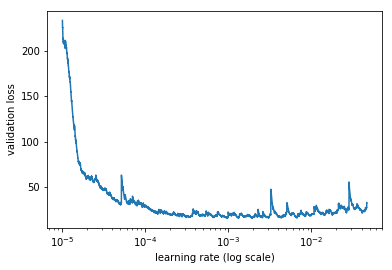

In [40]:
m.sched.plot()

In [41]:
lr = 3e-4
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                           
    0      17.427678  16.503585  3.915781  
    1      13.353421  14.759362  3.686045                       
    2      14.403327  14.695007  3.67905                        


[array([14.69501]), 3.679050492908292]

In [42]:
m.fit(lr, 5, metrics=[rmse], cycle_len=1)

epoch      trn_loss   val_loss   rmse                           
    0      12.384603  14.333513  3.627065  
    1      16.667979  14.309481  3.624052                       
    2      11.453099  14.303051  3.622487                       
    3      14.036224  14.305217  3.621415                       
    4      12.319324  14.331322  3.624798                       


[array([14.33132]), 3.624798207358289]

In [43]:
m.fit(lr, 2, metrics=[rmse], cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss   rmse                           
    0      12.348494  14.525467  3.64992   
    1      18.321224  14.397381  3.630461                       
    2      13.529635  14.660199  3.665392                       
    3      13.691499  14.805044  3.686117                       
    4      18.075978  14.478471  3.639105                       
    5      16.360884  14.501265  3.641898                       


[array([14.50127]), 3.641897665647558]

| features | arch | parameters | rmse | note |
| --- | --- | --- | --- | --- |
| LAT, LONG, passenger, DT embeding, location labels | [1000, 500, 100], drops:[0.001, 0.03 0.01] | lr=1e-4, bs=512 | ~3.606 | slight improve | 
| LAT, LONG, passenger, DT embeding, location labels | [1000, 500, 100], drops:[0.001, 0.01 0.01] | lr=1e-4, bs=512 | ~3.605 |  |
| LAT, LONG, passenger, DT embeding, location labels | [1000, 500, 100], drops:[0.001, 0.01 0.01] | lr=2e-4, bs=1024(up from 512) | ~3.66 |  |
| LAT, LONG, passenger, DT embeding, location labels | [1000, 500, 100], drops:[0.01, 0.01 0.01] | lr=1e-3, bs=512 | ~3.62  | overfit, reduce lr |